In [1]:
# clear variables
%reset -f

# libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import pandas as pd
from IPython.display import display
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Read Data
data = np.load('array_data/data_64.npy',allow_pickle=True)
labels = np.load('array_data/labels.npy',allow_pickle=True)

# Scale Data
scale_data = StandardScaler().fit_transform(data)

# Delete
del data

In [2]:
# Comparing Classifiers

# PCA
def pca(x_train, x_test, y_train):  
    # PCA
    pca = PCA(n_components=10, random_state=1)
    # fit
    x_train = pca.fit_transform(x_train)
    x_test = pca.fit_transform(x_test)
    # plot
    plot = plt.scatter(x_train[:,0], 
                       x_train[:,1], 
                       c=y_train,
                      s=5)
    plt.legend(handles=plot.legend_elements()[0], 
               labels=['No Finding','Finding'])
    plt.xlabel('1st Component')
    plt.ylabel('2nd Component')
    plt.title('PCA: Training Data')
    plt.show()
    return x_train, x_test

# ANN
def ann(x, y, test):
    print('Fitting ANN...')
    ## fit model
    ann = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
    ann.fit(x, y)
    ## predict
    ann_pred = ann.predict(test)
    return ann_pred

# KNN
def knn(x, y, test, k=None):
    print('Fitting KNN...')
    # no specified k
    if k==None:
        #create new a knn model
        knn = KNeighborsClassifier()
        #create a dictionary of all values we want to test for n_neighbors
        param_grid = {'n_neighbors': np.arange(1, 50)}
        #use gridsearch to test all values for n_neighbors
        knn_gscv = GridSearchCV(knn, param_grid, cv=10)
        #fit model to data
        knn_gscv.fit(x, y)
        print(knn_gscv.best_params_)
        ## predict
        knn_pred = knn_gscv.predict(test)
    # specified k
    else:
        ## fit 
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x, y)
        ## predict
        knn_pred = knn.predict(test)
    return knn_pred

# SVM
def svm(x, y, test):
    print('Fitting SVM...')
    ## fit model
    svm = SVC(kernel='rbf',
              random_state=1)
    svm.fit(x, y)
    ## predict
    svm_pred = svm.predict(test)
    return svm_pred

# Logistic Regression
def log_reg(x, y, test):
    print('Fitting Logistic Regression...')
    ## fit model
    log_reg = LogisticRegression(solver='saga',
                                random_state=1)
    log_reg.fit(x, y)
    ## predict
    log_pred = log_reg.predict(test)
    return log_pred

# Naive Bayes
def bayes(x, y, test):
    print('Fitting Naive Bayes...')
    ## fit model
    bayes = GaussianNB()
    bayes.fit(x, y)
    ## predict
    bayes_pred = bayes.predict(test)    
    return bayes_pred

# Gradient Boosting
def grad_boost(x, y, test):
    print('Fitting Gradient Boosting...')
    ## fit model
    grad = XGBClassifier(seed=1)
    grad.fit(x, y)
    ## predict
    grad_pred = grad.predict(test)
    return grad_pred

# K-Means
def kmeans(x,y):
    print('Fitting K-Means...')
    # K-Means
    kmeans = KMeans(n_clusters=2, random_state=1)
    kmeans.fit(x)
    ## labels
    cluster_labels = kmeans.labels_
    k_labels = np.zeros(cluster_labels.shape)    
    ## infer
    if sum(cluster_labels[np.where(y==0)[0]]) < sum(cluster_labels[np.where(y==1)[0]]):
        k_labels[cluster_labels == 0] = 0
        k_labels[cluster_labels == 1] = 1
    else:
        k_labels[cluster_labels == 0] = 1
        k_labels[cluster_labels == 1] = 0
    perf(y, k_labels)
    return k_labels

# Performance
def perf(pred, real):
    print('Confusion Matrix')
    # confusion matrix
    conf_mat = confusion_matrix(real,pred)
    display(pd.DataFrame(conf_mat))
    print('Classification Report')
    # classificaiton report
    class_rep = classification_report(real,pred,output_dict=True)
    display(pd.DataFrame(class_rep))

def roc_curves(pred_list, class_list, real):
    colors = plt.cm.tab10(np.linspace(0, 1, len(pred_list)))
    for pred, title, c in zip(pred_list,class_list, colors):
        # ROC Curve
        fpr, tpr, threshold = roc_curve(real, pred)
        # AUC
        roc_auc = auc(fpr, tpr)
        # plot
        plt.plot(fpr, tpr, 'b', 
                 label = str(title+': AUC = %0.2f' % roc_auc),
                c=c)
    # plot features
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Full Implementation
def run(model,x_train,y_train,x_test,y_test,k=None):
    if k == None:
        # Fit and Predict
        pred = model(x_train, y_train, x_test)
    else:
        # Fit and Predict
        pred = model(x_train, y_train, x_test, k=k)
    # Examine Performance
    perf(y_test, pred)
    return pred


Non-PCA Data
Fitting ANN...
Confusion Matrix


,0,1
0,489,238
1,302,553


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.618205,0.699115,0.65866,0.658660,0.661933
recall,0.672627,0.646784,0.65866,0.659705,0.658660
f1-score,0.644269,0.671932,0.65866,0.658100,0.659219
support,727.000000,855.000000,0.65866,1582.000000,1582.000000


Fitting KNN...
Confusion Matrix


,0,1
0,537,209
1,254,582


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.678887,0.735777,0.707332,0.707332,0.708951
recall,0.719839,0.696172,0.707332,0.708006,0.707332
f1-score,0.698764,0.715427,0.707332,0.707095,0.707569
support,746.000000,836.000000,0.707332,1582.000000,1582.000000


Fitting SVM...
Confusion Matrix


,0,1
0,552,175
1,239,616


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.697851,0.778761,0.738306,0.738306,0.741579
recall,0.759285,0.720468,0.738306,0.739876,0.738306
f1-score,0.727273,0.748481,0.738306,0.737877,0.738735
support,727.000000,855.000000,0.738306,1582.000000,1582.000000


Fitting Logistic Regression...
Confusion Matrix


/Users/joshtkraus/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,0,1
0,494,278
1,297,513


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.624526,0.648546,0.636536,0.636536,0.636825
recall,0.639896,0.633333,0.636536,0.636615,0.636536
f1-score,0.632118,0.640849,0.636536,0.636484,0.636588
support,772.000000,810.000000,0.636536,1582.000000,1582.000000


Fitting Naive Bayes...
Confusion Matrix


,0,1
0,516,217
1,275,574


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.652339,0.725664,0.689001,0.689001,0.691690
recall,0.703956,0.676090,0.689001,0.690023,0.689001
f1-score,0.677165,0.700000,0.689001,0.688583,0.689420
support,733.000000,849.000000,0.689001,1582.000000,1582.000000


Fitting Gradient Boosting...
Confusion Matrix


,0,1
0,568,183
1,223,608


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.718078,0.768647,0.743363,0.743363,0.744641
recall,0.756325,0.731649,0.743363,0.743987,0.743363
f1-score,0.736706,0.749692,0.743363,0.743199,0.743527
support,751.000000,831.000000,0.743363,1582.000000,1582.000000


Fitting K-Means...
Confusion Matrix


,0,1
0,415,325
1,376,466


Classification Report


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.524652,0.589128,0.55689,0.556890,0.558969
recall,0.560811,0.553444,0.55689,0.557127,0.556890
f1-score,0.542129,0.570729,0.55689,0.556429,0.557351
support,740.000000,842.000000,0.55689,1582.000000,1582.000000


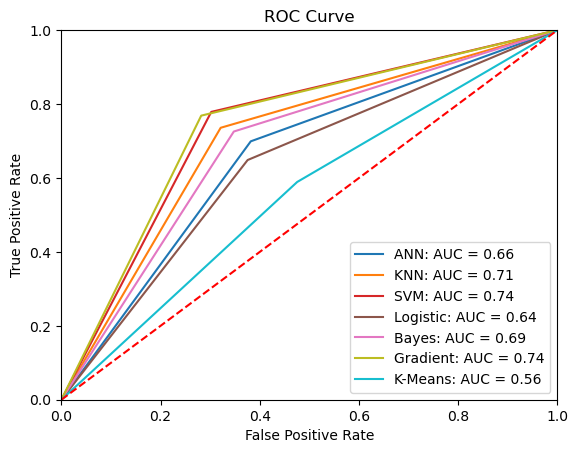

PCA Data


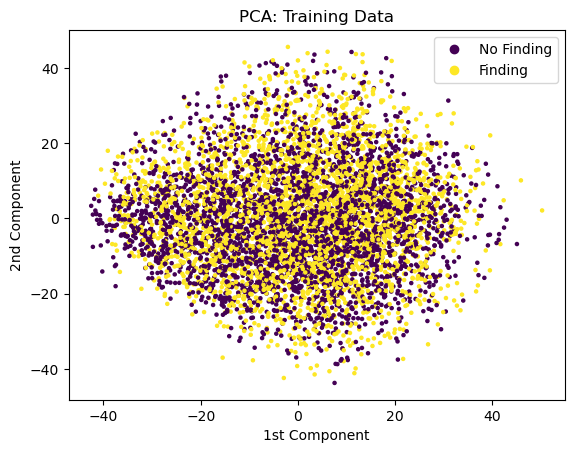

Fitting ANN...
Confusion Matrix


,0,1
0,512,261
1,279,530


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.647282,0.670038,0.65866,0.658660,0.658919
recall,0.662354,0.655130,0.65866,0.658742,0.658660
f1-score,0.654731,0.662500,0.65866,0.658616,0.658704
support,773.000000,809.000000,0.65866,1582.000000,1582.000000


Fitting KNN...
{'n_neighbors': 41}
Confusion Matrix


,0,1
0,532,239
1,259,552


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.672566,0.697851,0.685209,0.685209,0.685528
recall,0.690013,0.680641,0.685209,0.685327,0.685209
f1-score,0.681178,0.689139,0.685209,0.685158,0.685259
support,771.000000,811.000000,0.685209,1582.000000,1582.000000


Fitting SVM...
Confusion Matrix


,0,1
0,550,240
1,241,551


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.695322,0.696587,0.695954,0.695954,0.695955
recall,0.696203,0.695707,0.695954,0.695955,0.695954
f1-score,0.695762,0.696147,0.695954,0.695954,0.695955
support,790.000000,792.000000,0.695954,1582.000000,1582.000000


Fitting Logistic Regression...
Confusion Matrix


,0,1
0,521,249
1,270,542


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.658660,0.685209,0.671934,0.671934,0.672287
recall,0.676623,0.667488,0.671934,0.672056,0.671934
f1-score,0.667521,0.676232,0.671934,0.671876,0.671992
support,770.000000,812.000000,0.671934,1582.000000,1582.000000


Fitting Naive Bayes...
Confusion Matrix


,0,1
0,502,232
1,289,559


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.634640,0.706700,0.67067,0.670670,0.673266
recall,0.683924,0.659198,0.67067,0.671561,0.670670
f1-score,0.658361,0.682123,0.67067,0.670242,0.671098
support,734.000000,848.000000,0.67067,1582.000000,1582.000000


Fitting Gradient Boosting...
Confusion Matrix


,0,1
0,517,265
1,274,526


Classification Report


,0,1,accuracy,macro avg,weighted avg
precision,0.653603,0.664981,0.659292,0.659292,0.659357
recall,0.661125,0.657500,0.659292,0.659313,0.659292
f1-score,0.657343,0.661219,0.659292,0.659281,0.659303
support,782.000000,800.000000,0.659292,1582.000000,1582.000000


Fitting K-Means...
Confusion Matrix


,0,1
0,406,328
1,385,463


Classification Report


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.513274,0.585335,0.549305,0.549305,0.551901
recall,0.553134,0.545991,0.549305,0.549562,0.549305
f1-score,0.532459,0.564979,0.549305,0.548719,0.549891
support,734.000000,848.000000,0.549305,1582.000000,1582.000000


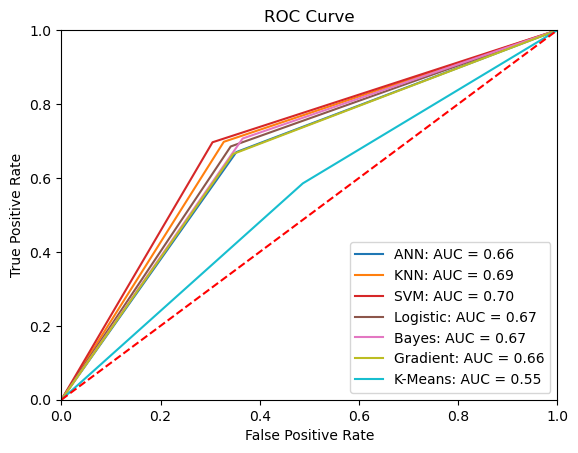

In [3]:
# No Finding vs. Effusion, Balanced

# Subset Infiltration & No Finding
## subset
data_sub = scale_data[:,np.where((labels=='No Finding')|(labels=='Effusion'))[0]]
label_sub = labels[np.where((labels=='No Finding')|(labels=='Effusion'))[0]]
## convert response to binary
label_bin = np.where(label_sub == 'No Finding', 0, 1)

# Delete
del label_sub, scale_data, labels

# Balance (Undersampliung)
## separate
no_finding = np.where(label_bin==0)[0]
finding = np.where(label_bin==1)[0]
## set seed
np.random.seed(1)
## under sample
no_finding = np.random.choice(no_finding,
                              len(finding),
                              replace=False)
## indicies
ind = np.append(no_finding,finding)
## balance
data_small = data_sub[:,ind]
label_small = label_bin[ind]

# Delete
del no_finding, finding, ind, data_sub, label_bin

# Split Data
(x_train,x_test,
y_train,y_test) = train_test_split(data_small.T,label_small, 
                                       test_size=0.2, random_state=1,
                                       shuffle=True,stratify=label_small)

# Delete
del data_small, label_small

# Non-PCA Fitting (higher accuracy, slower computation)
print('Non-PCA Data')
# ANN
ann_pred = run(ann,x_train,y_train,x_test,y_test)
# KNN
knn_pred = run(knn,x_train,y_train,x_test,y_test,k=49) # takes long time to run, have specific k for now
# SVM
svm_pred = run(svm,x_train,y_train,x_test,y_test)
# Logistic Regression
log_pred = run(log_reg,x_train,y_train,x_test,y_test)
# Bayes
bayes_pred = run(bayes,x_train,y_train,x_test,y_test)
# Gradient Boosting
grad_pred = run(grad_boost,x_train,y_train,x_test,y_test)
# K-Means
kmeans_pred = kmeans(x_test,y_test)
# Plot ROC
pred_list = [ann_pred,knn_pred,svm_pred,log_pred,bayes_pred,grad_pred,kmeans_pred]
class_list = ['ANN','KNN','SVM','Logistic','Bayes','Gradient','K-Means']
roc_curves(pred_list, class_list, y_test)

# Delete
del pred_list,ann_pred,knn_pred,svm_pred,log_pred,bayes_pred,grad_pred,kmeans_pred

# PCA Fitting (lower accuracy, faster computation)
print('PCA Data')
# PCA
x_train_pca, x_test_pca = pca(x_train, x_test, y_train)

# Delete
del x_train, x_test

# ANN
ann_pred = run(ann,x_train_pca,y_train,x_test_pca,y_test)
# KNN
knn_pred = run(knn,x_train_pca,y_train,x_test_pca,y_test)
# SVM
svm_pred = run(svm,x_train_pca,y_train,x_test_pca,y_test)
# Logistic Regression
log_pred = run(log_reg,x_train_pca,y_train,x_test_pca,y_test)
# Bayes
bayes_pred = run(bayes,x_train_pca,y_train,x_test_pca,y_test)
# Gradient Boosting
grad_pred = run(grad_boost,x_train_pca,y_train,x_test_pca,y_test)
# K-Means
kmeans_pred = kmeans(x_test_pca,y_test)
# Plot ROC
pred_list = [ann_pred,knn_pred,svm_pred,log_pred,bayes_pred,grad_pred,kmeans_pred]
roc_curves(pred_list, class_list, y_test)

# Delete
del y_train, y_test, x_train_pca, x_test_pca